# A Google Meridian PyMC-Marketing Comparison

Intro here

In [1]:
# Standard imports
import re
import time
import warnings

# IPython and Jupyter-specific
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Third-party imports
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import xarray as xr
from pympler import asizeof
from statsmodels.stats.stattools import durbin_watson

# PyMC Marketing
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import (
    MMM,
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

# Meridian
from meridian import constants
from meridian.analysis import analyzer, formatter, optimizer, summarizer, visualizer
from meridian.data import (
    data_frame_input_data_builder,
    input_data,
    load,
    test_utils,
)
from meridian.model import model, prior_distribution, spec

# Warnings and plotting style
warnings.filterwarnings("ignore", category=UserWarning)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [2]:
# Set random seed for reproduceability
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## The Data

A description of the data

In [3]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"]).rename(columns={"date_week": "date"})

a_data_df = raw_data_df.copy().assign(geo="geo_a")
b_data_df = raw_data_df.copy().assign(geo="geo_b")

# Add noise to the target variable for the second geo
b_data_df["y"] = b_data_df["y"] + 500 * rng.normal(size=len(b_data_df))

# Concatenate the two datasets
data_df = pd.concat([a_data_df, b_data_df])

# We want all geos scaled equally.
data_df['population'] = 1

# Naming convention
data_df = data_df.rename(columns = {"date": "time"})

In [4]:
# Collect channel columns
channel_columns = [col for col in data_df.columns if re.fullmatch(r"x\d+", col)]
n_channels = len(channel_columns)

## Data Pre-Processing

In [5]:
# Meridian

builder = (
    data_frame_input_data_builder.DataFrameInputDataBuilder(kpi_type='revenue')
    .with_kpi(data_df, kpi_col="y")
    .with_population(data_df)
    .with_controls(
        data_df, control_cols=["event_1", "event_2"]
    )
    .with_media(
    data_df,
    media_cols=channel_columns,
    media_spend_cols=channel_columns,
    media_channels=channel_columns,
    )
)

data = builder.build()

# PyMC-Marketing
# None required.

## Prior Specification 

**Meridian**

- Uses spend share as prior variance for $\beta$ parameters, across channels - does not allow for geo level.
- Hierarchical structure accross the saturation parameters - Meridian does this by default.
- Setting knots to occur every 26 weeks, to best align with seasonality of order 2.

**PyMC-Marketing**

- Using spend share as prior for $\beta$ parameters, across channels and geos.
- Hierarchical structure accross the saturation parameters.
- Includes fourier seasonality of order 2.

In [6]:
# Spend share priors
sum_spend_geo_channel = data_df.groupby("geo")[channel_columns].sum()

spend_share = (
    sum_spend_geo_channel.to_numpy() / sum_spend_geo_channel.sum(axis=1).to_numpy()[:, None]
)

prior_sigma = n_channels * spend_share

In [7]:
# Meridian

n_time = len(data.time)
knots = np.arange(0, n_time, 26).tolist() # ~ seasonality of order 2

build_media_channel_args = data.get_paid_media_channels_argument_builder()

beta_m = build_media_channel_args(
  x1=(0, float(prior_sigma.mean(axis = 0)[0])),
  x2=(0, float(prior_sigma.mean(axis = 0)[1])),
) 
beta_m_mu, beta_m_sigma = zip(*beta_m)

prior = prior_distribution.PriorDistribution(
    beta_m=tfp.distributions.LogNormal(
        beta_m_mu, beta_m_sigma, name=constants.BETA_M
    )
)

# PyMC-Marketing

model_config = {
    'gamma_control': Prior("Normal", mu=0, sigma=2, dims=("control", "geo"))
}
saturation = LogisticSaturation(
    priors={
        "beta": Prior("LogNormal", sigma=prior_sigma, dims=("channel", "geo")),
        "lam": Prior(
            "Gamma",
            mu=Prior("LogNormal", mu=np.log(3), sigma=np.log(1.5), dims="channel"),
            sigma=Prior("LogNormal", mu=np.log(1), sigma=np.log(1.5), dims="channel"),
            dims=("channel", "geo"),
        ),
    }
)

## Model Specification

**Meridian**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_{t} +\tau_{g} + \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right) + \epsilon_{g,t}
$$

Where:

- $\mu_{t}$ represents the intercept at time $t$.
- $\tau_{g}$ represents the intercept for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

----

**PyMC-Marketing**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_g + \sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right) + \epsilon_{g,t}
$$

Where:

- $\mu_g$ represents the intercept for geo g.
- $\sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i}$ represents the seasonality/fourier contribution (order 2) at time $t$ for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

In [8]:
# Meridian

model_spec = spec.ModelSpec(
    prior=prior,
    media_effects_dist='log_normal',
    hill_before_adstock=False,
    max_lag=8,
    unique_sigma_for_each_geo=True,
    roi_calibration_period=None,
    rf_roi_calibration_period=None,
    knots=knots,
    baseline_geo=None,
    holdout_id=None,
    control_population_scaling_id=None,
    media_prior_type = 'coefficient',
    rf_prior_type = 'coefficient',
)

# PyMC-Marketing

mmm = MMM(
    date_column="time",
    target_column="y",
    channel_columns=channel_columns,
    control_columns=["event_1", "event_2"],
    dims=("geo",),
    scaling={
        "channel": {"method": "max", "dims": ()},
        "target": {"method": "max", "dims": ()},
    },
    saturation=saturation,
    adstock = GeometricAdstock(l_max = 8),
    yearly_seasonality=2,
    model_config = model_config
)

## Model Building

In [9]:
# Meridian

meridian = model.Meridian(input_data=data, model_spec=model_spec)

# PyMC-Marketing

x_train = data_df.drop(columns=["y"])
y_train = data_df["y"]

mmm.build_model(X=x_train, y=y_train)
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "control_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]
)

I0000 00:00:1751901305.886177 10963166 service.cc:148] XLA service 0x6000031f0200 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751901305.886204 10963166 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1751901305.893197 10963166 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## Prior Sampling

In [11]:
# Meridian

meridian.sample_prior(1000)

# PyMC-Marketing

prior_predictive = mmm.sample_prior_predictive(X=x_train, y=y_train, samples=1_000)
scalers = mmm.get_scales_as_xarray()

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, y, y_sigma]


## Posterior Sampling
We aim to observe the following:
- Speed comparisons
- Memory comparisons
- Convergence analysis

In [12]:
# Meridian

start = time.perf_counter()

meridian.sample_posterior(
    n_chains=4, 
    n_adapt=1000, 
    n_burnin=500, 
    n_keep=1000)

end = time.perf_counter()
print(f"Meridian sampling took {end - start:.2f} seconds.")

# PyMC-Marketing

start = time.perf_counter()

mmm.fit(
    X=x_train,
    y=y_train,
    chains=4,
    draws=1000,
    tune=500,
    target_accept=0.95,
    random_seed=rng,
)

end = time.perf_counter()
print(f"PyMC-Marketing sampling took {end - start:.2f} seconds.")

start = time.perf_counter()

mmm.sample_posterior_predictive(
    X=x_train,
    extend_idata=True,
    combined=True,
    random_seed=rng,
)

end = time.perf_counter()
print(f"PyMC-Marketing sampling of the posterior predictive took {end - start:.2f} seconds.")

2025-07-07 16:22:41.303515: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1751901761.516077 10963166 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


Meridian sampling took 78.23 seconds.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam_mu, saturation_lam_sigma, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 14 seconds.
Sampling: [y]


Output()

PyMC-Marketing sampling took 20.80 seconds.


PyMC-Marketing sampling of the posterior predictive took 0.23 seconds.


**Note** PyMC-Marketing stores the data and contributions as a part of the model object, meridian does not.

In [15]:
# Meridian

model_size = asizeof.asizeof(meridian)
print(f"Meridian model size: {model_size / (1024 ** 2):.2f} MB")

# PyMC-Marketing

model_size = asizeof.asizeof(mmm)
print(f"PyMC-Marketing model size: {model_size / (1024 ** 2):.2f} MB")

Meridian model size: 4.84 MB
PyMC-Marketing model size: 211.51 MB


In [33]:
# Meridian

divergences = meridian.inference_data.sample_stats.diverging.sum().item()
print(f"Meridian number of divergences: {divergences}")

r_hat_max = az.summary(
    meridian.inference_data,
    var_names=[
        "alpha_m",
        "beta_gm",
        "beta_m",
        "ec_m",
        "gamma_c",
        "gamma_gc",
        "sigma",
        "tau_g",
        "xi_c",
        "knot_values",
        "mu_t",
    ]
)['r_hat'].max()

print(f"Meridian maximum r_hat: {r_hat_max}")

# PyMC-Marketing

divergences = mmm.idata.sample_stats.diverging.sum().item()
print(f"PyMC-Marketing number of divergences: {divergences}")

r_hat_max = az.summary(
    mmm.idata,
    var_names=[
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
        "intercept_contribution",
        "saturation_beta",
        "saturation_lam_mu",
        "saturation_lam_sigma",
        "saturation_lam",
        "y_sigma",
    ],
)['r_hat'].max()

print(f"PyMC-Marketing maximum r_hat: {r_hat_max}")

Meridian number of divergences: 174


/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Meridian maximum r_hat: 1.01
PyMC-Marketing number of divergences: 0
PyMC-Marketing maximum r_hat: 1.0


## Predictive Performance

#### Meridian

In [47]:
model_fit = visualizer.ModelFit(meridian)
model_fit.plot_model_fit(
    n_top_largest_geos=2,
    show_geo_level=True,
    include_baseline=False,
    include_ci=True
)

alt.FacetChart(...)

In [52]:
model_analysis = analyzer.Analyzer(meridian)
fit_data = model_analysis.expected_vs_actual_data()

    
results = []

for geo in fit_data.geo.values:
    expected = fit_data['expected'].sel(geo=geo, metric = "mean")
    actual = fit_data['actual'].sel(geo=geo)

    expected_vals = expected.values
    actual_vals = actual.values

    mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
    expected_vals = expected_vals[mask]
    actual_vals = actual_vals[mask]

    if len(expected_vals) < 3:
        continue  # not enough data

    # R² (manual)
    ss_res = np.sum((actual_vals - expected_vals) ** 2)
    ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

    # MAPE
    nonzero_mask = actual_vals != 0
    mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

    # Durbin-Watson
    residuals = actual_vals - expected_vals
    dw = durbin_watson(residuals)

    results.append({
        "geo": geo,
        "R²": round(r2, 4) if not np.isnan(r2) else None,
        "MAPE (%)": round(mape, 2),
        "Durbin-Watson": round(dw, 3)
    })
performance_table = pd.DataFrame(results).sort_values("geo")
display(performance_table)

,geo,R²,MAPE (%),Durbin-Watson
0,geo_a,0.7606,8.31,0.454
1,geo_b,0.6498,10.71,1.206


#### PyMC-Marketing

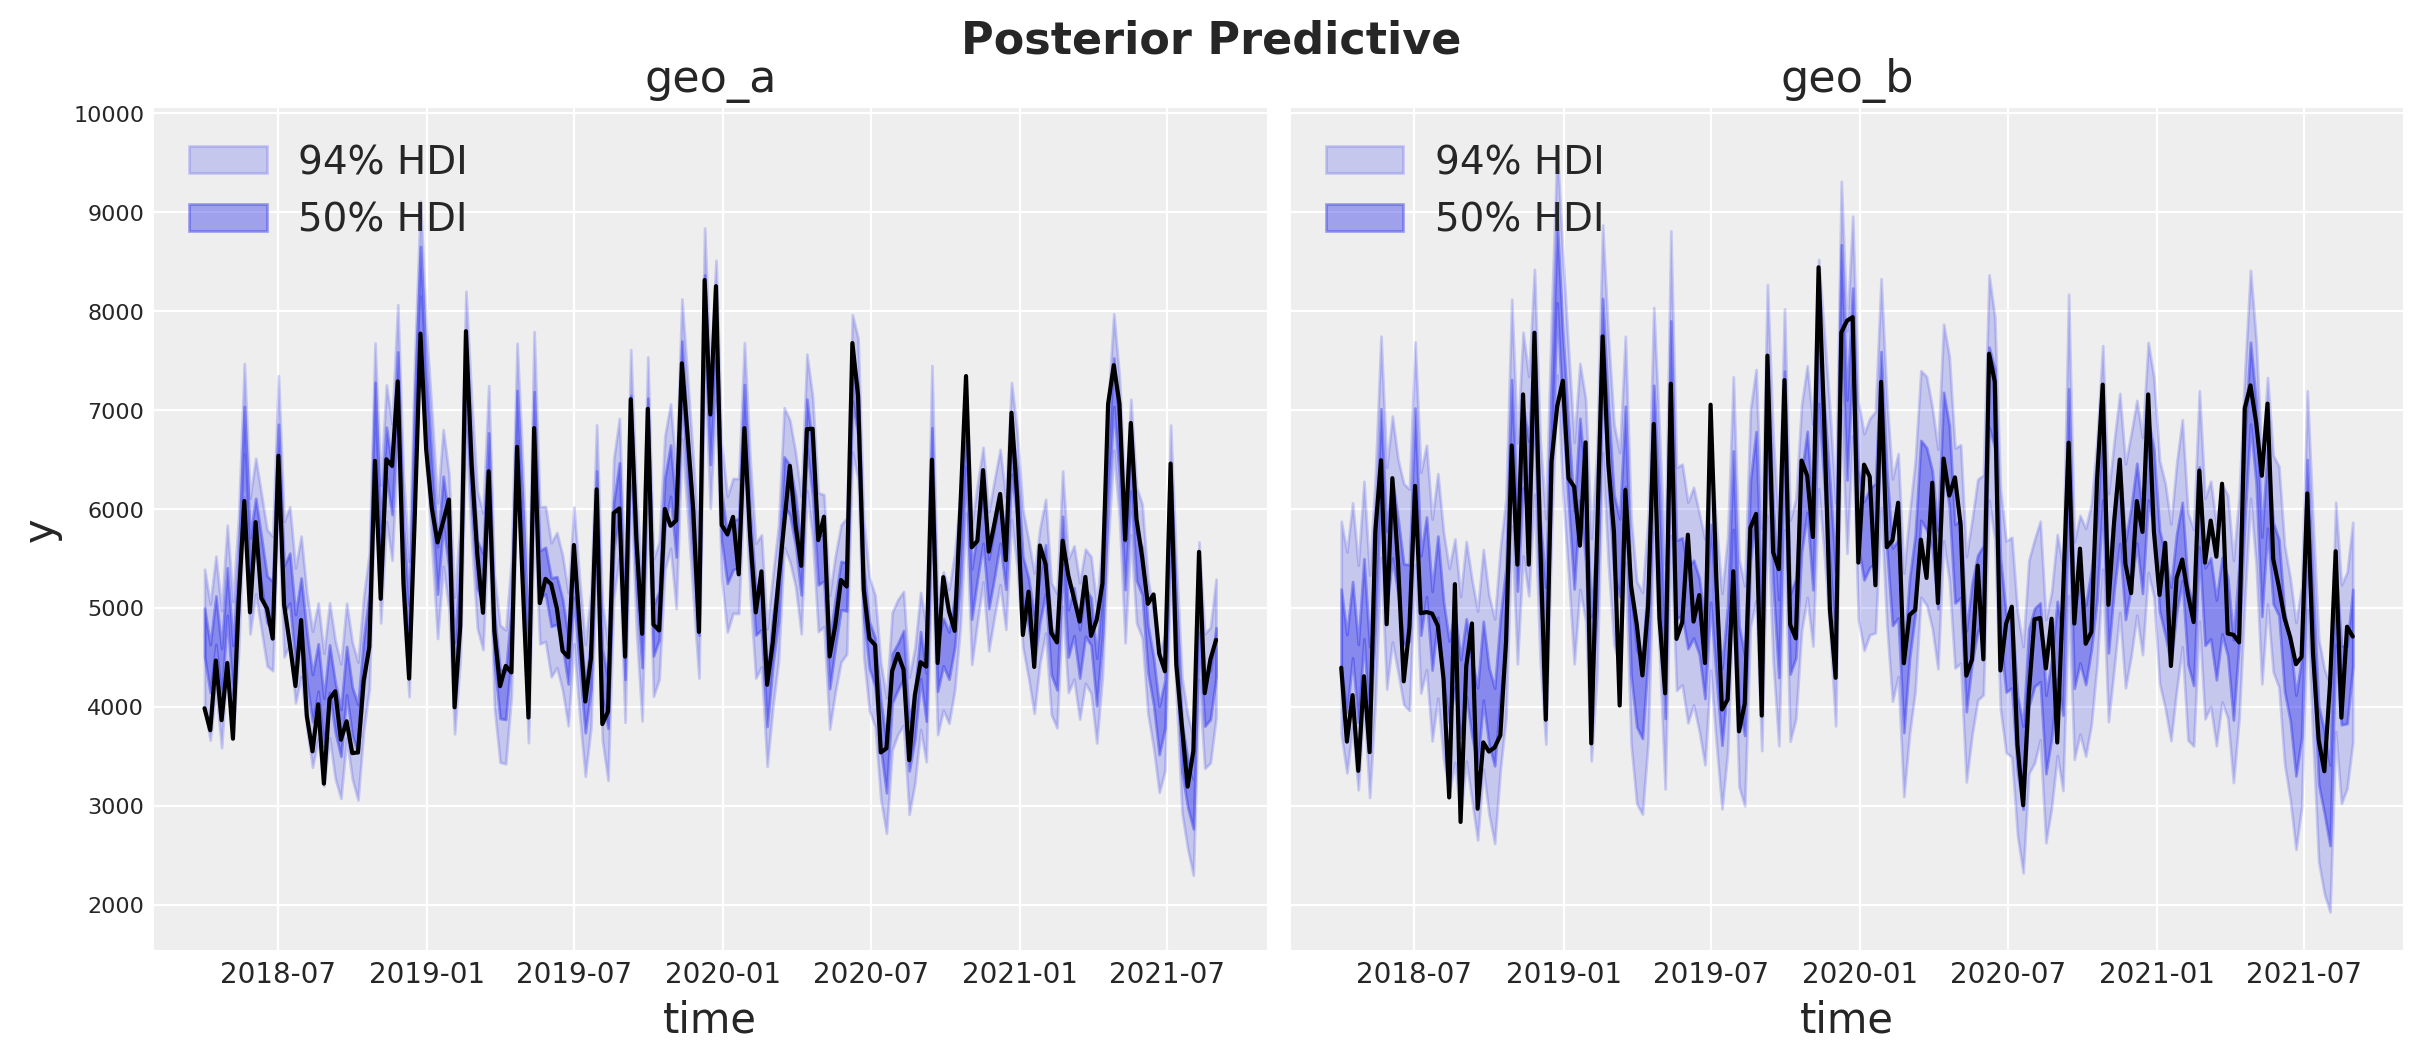

In [46]:
fig, axes = plt.subplots(
    ncols=len(mmm.model.coords["geo"]),
    figsize=(12, 5),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(mmm.idata["posterior_predictive"].y_original_scale.sel(geo=geo)),
        color="C0",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.2, "label": "94% HDI"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(mmm.idata["posterior_predictive"].y_original_scale.sel(geo=geo)),
        color="C0",
        smooth=False,
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.4, "label": "50% HDI"},
        ax=ax,
    )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="time",
        y="y",
        color="black",
        ax=ax,
    )

    ax.legend(loc="upper left")
    ax.set(title=f"{geo}")

fig.suptitle("Posterior Predictive", fontsize=16, fontweight="bold", y=1.03);

In [55]:
results = []

for geo in mmm.model.coords["geo"]:
    expected = mmm.idata["posterior_predictive"].y_original_scale.mean(['chain','draw']).sel(geo = geo)
    actual_vals = data_df.loc[data_df["geo"] == geo, "y"]

    expected_vals = expected.values
    actual_vals = actual_vals.values

    mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
    expected_vals = expected_vals[mask]
    actual_vals = actual_vals[mask]

    if len(expected_vals) < 3:
        continue  # not enough data

    # R² (manual)
    ss_res = np.sum((actual_vals - expected_vals) ** 2)
    ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

    # MAPE
    nonzero_mask = actual_vals != 0
    mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

    # Durbin-Watson
    residuals = actual_vals - expected_vals
    dw = durbin_watson(residuals)

    results.append({
        "geo": geo,
        "R²": round(r2, 4) if not np.isnan(r2) else None,
        "MAPE (%)": round(mape, 2),
        "Durbin-Watson": round(dw, 3)
    })
performance_table = pd.DataFrame(results).sort_values("geo")
display(performance_table)

,geo,R²,MAPE (%),Durbin-Watson
0,geo_a,0.9001,5.47,0.968
1,geo_b,0.7647,9.23,1.751


## Contribution Recovery

In [56]:
# Meridian - predictions

incremental_df = model_analysis.incremental_outcome(aggregate_times=False, aggregate_geos=False, use_kpi=True)

mean_np = mean_contributions = tf.reduce_mean(incremental_df, axis=[0,1]).numpy()
lower_np = tfp.stats.percentile(incremental_df, 3, axis=[0,1]).numpy()
upper_np = tfp.stats.percentile(incremental_df, 97, axis=[0,1]).numpy()

stacked = tf.stack([mean_np, lower_np, upper_np], axis=0).numpy()

contrib_da = xr.DataArray(
    stacked,
    dims=["hdi", "geo", "time", "media_channel"],
    coords={
        "hdi": ["mean", "lower", "upper"],
        "geo": data.geo.coords['geo'].values,
        "time": data.time.coords['time'].values,
        "media_channel": data.media.coords['media_channel'].values
    },
    name="contribution"
)

predicted_contributions_ds_meridian = contrib_da.to_dataset()

# PyMC-Marketing - predictions 

predicted_contributions_ds_pymc_marketing = mmm.idata["posterior"]["channel_contribution_original_scale"]

In [57]:
# Read true contributions
# true_contributions = pd.read_csv("true_output_data.csv")

In [58]:
# ---------------------------TO BE DELETED ----------------------------
contrib_df = data_df.copy()

channel_cols = [col for col in contrib_df.columns if col.startswith("x")]

for col in channel_cols:
    scaling = np.random.uniform(1000, 2000)
    contrib_df[col] = contrib_df[col] * scaling

long_contrib_df = contrib_df.melt(
    id_vars=["time", "geo"],
    value_vars=[col for col in channel_cols],
    var_name="media_channel",
    value_name="contribution"
)

long_contrib_df["media_channel"] = long_contrib_df["media_channel"]

long_contrib_df["time"] = pd.to_datetime(long_contrib_df["time"])

true_contributions_da = (
    long_contrib_df
    .set_index(["time", "geo", "media_channel"])
    .to_xarray()
)["contribution"]

true_contributions_ds = true_contributions_da.to_dataset(name="contribution")
# ---------------------------------------------------------------------

#### Meridian

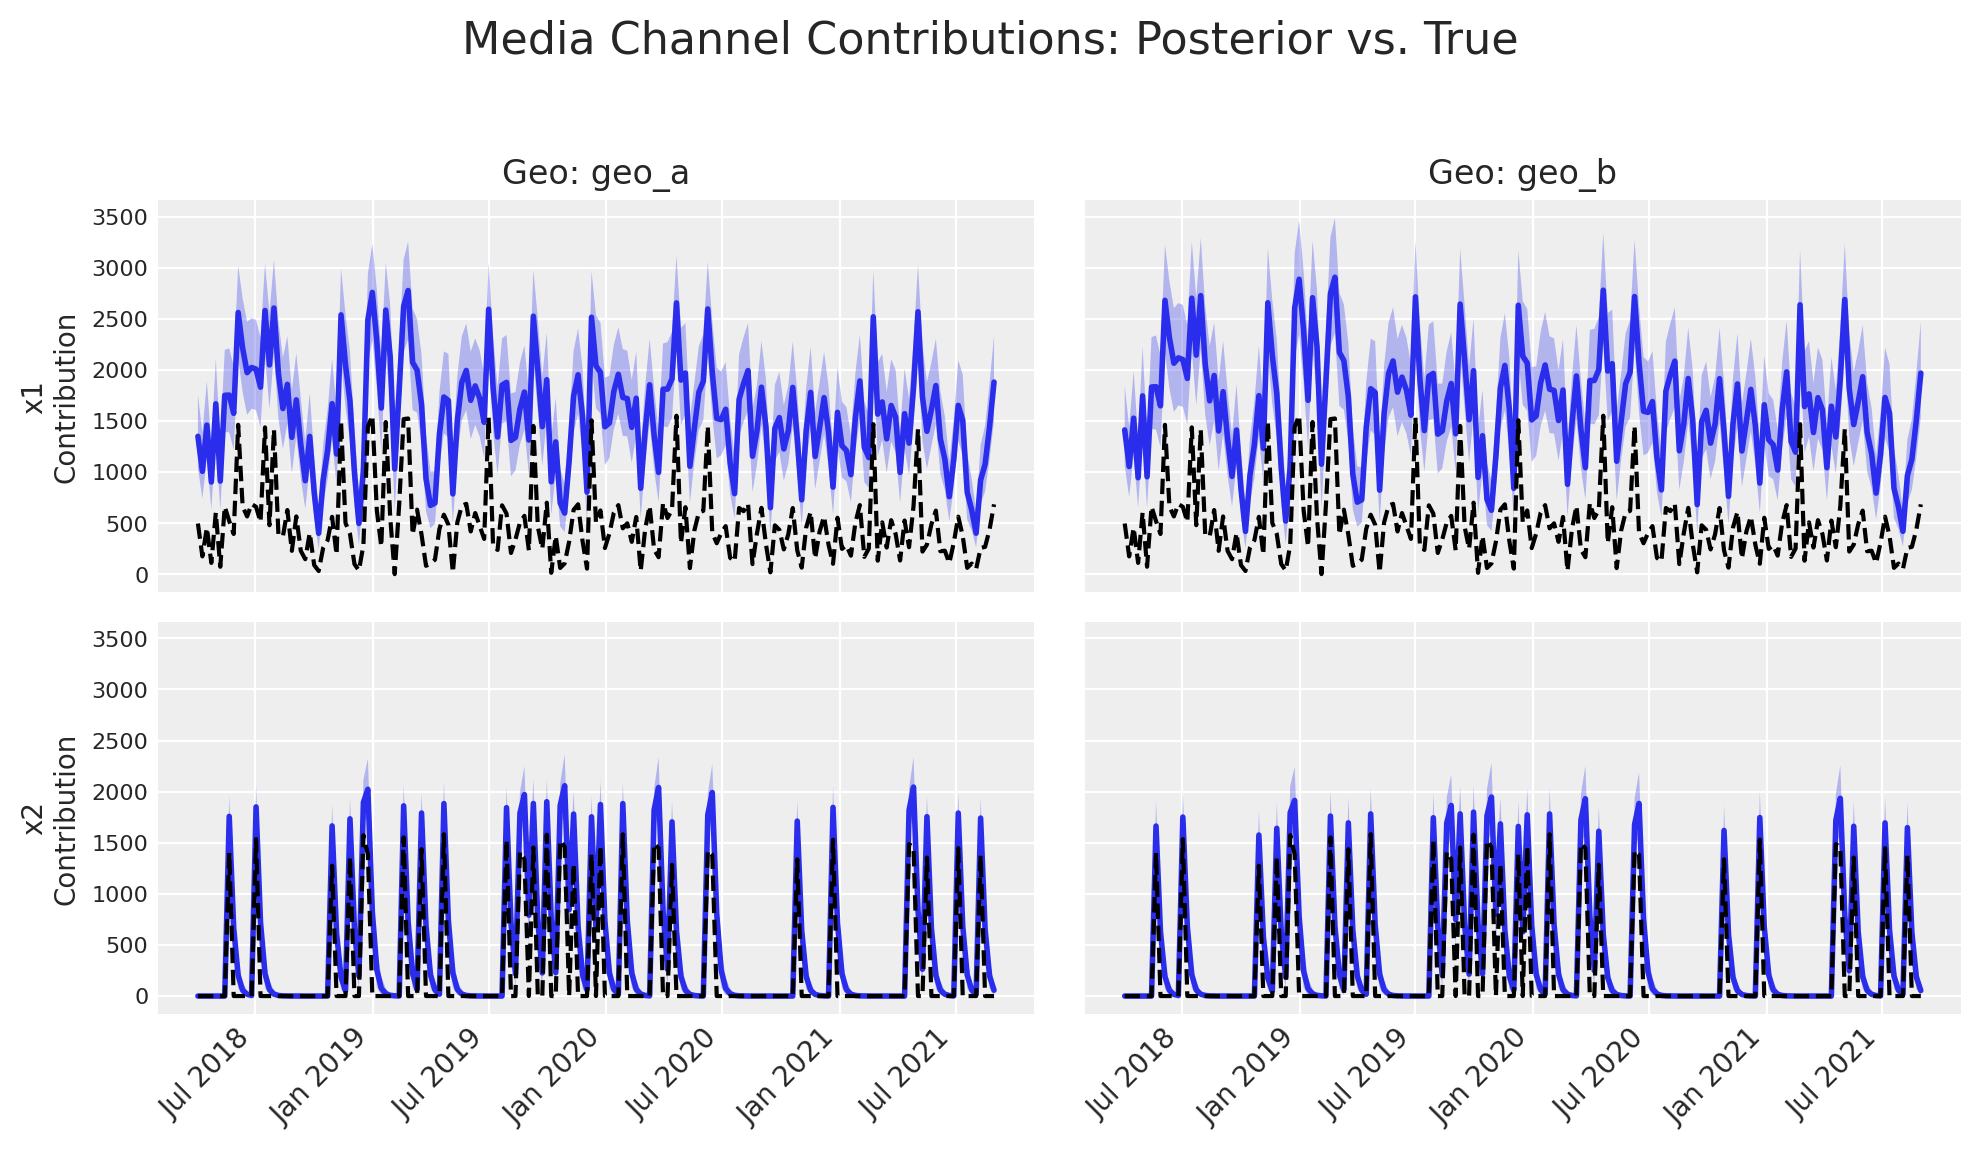

In [59]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (lower and upper), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Posterior Dataset with dims (hdi, geo, time, media_channel)
                                                     and coords hdi=["mean", "lower", "upper"].
        true_contributions_ds (xarray.Dataset): True contributions Dataset with dims
                                                (time, geo, media_channel) and variable "contribution".
    """
    da = predicted_contributions_ds["contribution"]

    geos = da.geo.values
    channels = da.media_channel.values
    time = pd.to_datetime(da.time.values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True, sharey=True)
    axs = np.atleast_2d(axs)

    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            # Posterior mean + HDI
            mean = da.sel(hdi="mean", geo=geo, media_channel=channel)
            lower = da.sel(hdi="lower", geo=geo, media_channel=channel)
            upper = da.sel(hdi="upper", geo=geo, media_channel=channel)

            ax.plot(time, mean, label="Mean", linewidth=2)
            ax.fill_between(time, lower, upper, alpha=0.3, label="HDI (3%–97%)")

            # True contribution (from xarray)
            try:
                truth = true_contributions_ds["contribution"].sel(geo=geo, media_channel=channel)
                truth = truth.sel(time=time) 
                ax.plot(time, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            except KeyError:
                pass  # Skip if combo not available

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_contributions_grid_with_truth(predicted_contributions_ds_meridian, true_contributions_ds)

In [62]:
def compute_mape_table(predicted_ds, true_ds):
    """
    Computes MAPE between predicted and true contributions for each (geo, media_channel) pair.

    Parameters:
        predicted_ds (xarray.Dataset): Dataset with dims (hdi, geo, time, media_channel)
        true_ds (xarray.Dataset): Dataset with dims (time, geo, media_channel)
        hdi_level (str): Which hdi level to use (default: "mean")

    Returns:
        pd.DataFrame: Table with columns: geo, media_channel, MAPE (%)
    """
    # Select the mean prediction
    pred_da = predicted_ds["contribution"].sel(hdi='mean')
    true_da = true_ds["contribution"]

    results = []

    for geo in pred_da.coords["geo"].values:
        for channel in pred_da.coords["media_channel"].values:
            try:
                # Select predicted and true time series
                pred = pred_da.sel(geo=geo, media_channel=channel)
                true = true_da.sel(geo=geo, media_channel=channel)

                # Convert to pandas Series indexed by time
                pred_series = pd.Series(pred.values, index=pred.coords["time"].values)
                true_series = pd.Series(true.values, index=true.coords["time"].values)
                pred_series.index = pd.to_datetime(pred_series.index)
                true_series.index = pd.to_datetime(true_series.index)

                # Join and clean
                df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                df = df[df["true"] != 0]

                if not df.empty:
                    mape = (np.abs((df["true"] - df["pred"]) / df["true"])).mean() * 100
                    results.append({
                        "geo": geo,
                        "media_channel": channel,
                        "MAPE (%)": round(mape, 2)
                    })

            except KeyError:
                continue

    return pd.DataFrame(results).sort_values(["geo", "media_channel"])
mape_df = compute_mape_table(predicted_contributions_ds_meridian, true_contributions_ds)
mape_df

,geo,media_channel,MAPE (%)
0,geo_a,x1,831.42
1,geo_a,x2,28.42
2,geo_b,x1,874.70
3,geo_b,x2,21.52


#### PyMC-Marketing

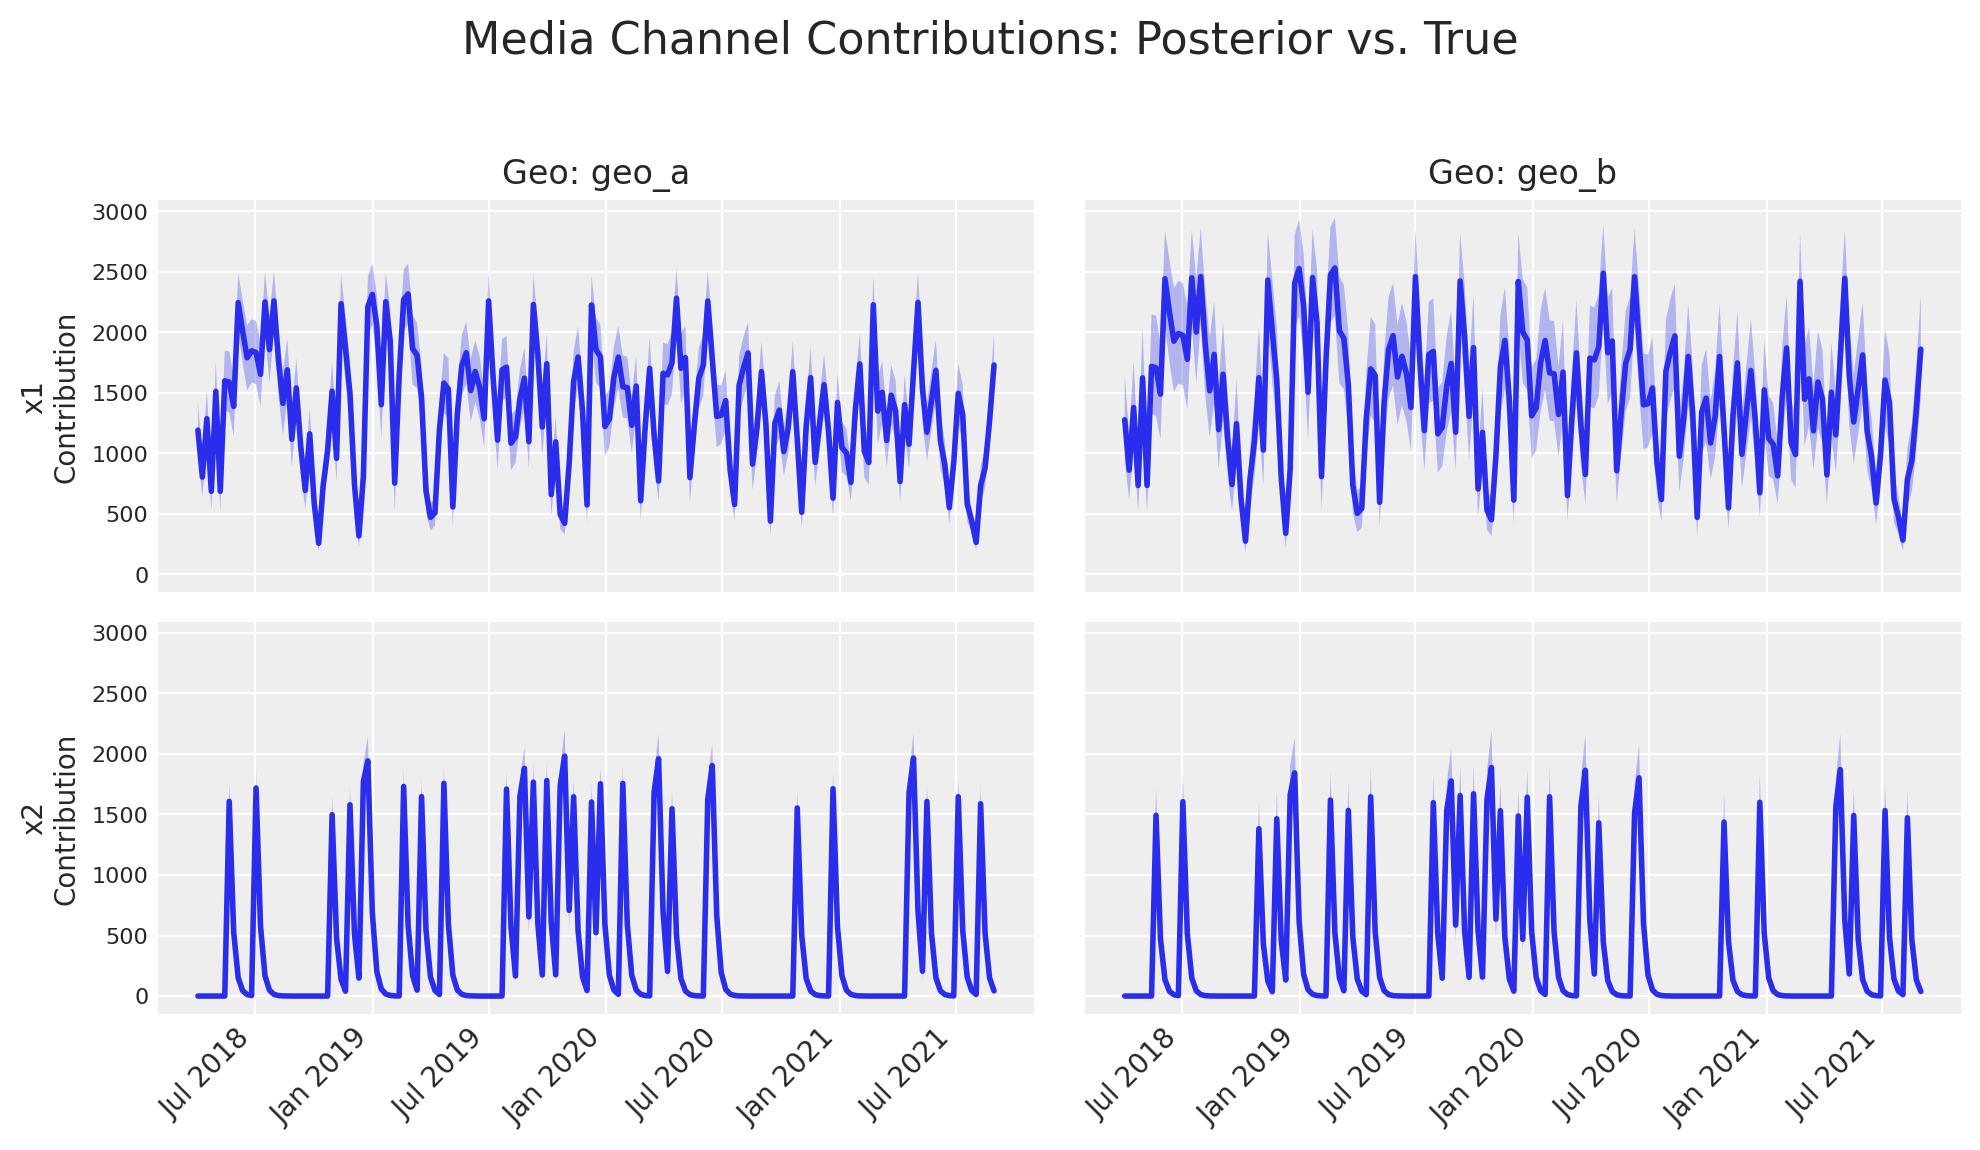

In [63]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (3rd–97th percentiles), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Dataset with dims (chain, draw, date, geo, channel)
        true_contributions_ds (xarray.Dataset): Dataset with dims (date, geo, channel)
    """
    # Extract data
    da = predicted_contributions_ds

    # Collapse (chain, draw) into posterior samples axis
    stacked = da.stack(sample=("chain", "draw"))

    # Compute posterior mean and HDI bounds
    mean = stacked.mean(dim="sample")
    lower = stacked.quantile(0.03, dim="sample")
    upper = stacked.quantile(0.97, dim="sample")

    geos = da.coords["geo"].values
    channels = da.coords["channel"].values
    dates = pd.to_datetime(da.coords["date"].values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=True, sharey=True)
    axs = np.atleast_2d(axs)

    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            mean_ts = mean.sel(geo=geo, channel=channel)
            lower_ts = lower.sel(geo=geo, channel=channel)
            upper_ts = upper.sel(geo=geo, channel=channel)

            ax.plot(dates, mean_ts, label="Mean", linewidth=2)
            ax.fill_between(dates, lower_ts, upper_ts, alpha=0.3, label="HDI (3%–97%)")

            # Plot true contributions
            try:
                truth = true_contributions_ds["contribution"].sel(geo=geo, media_channel=channel)
                truth = truth.sel(date=dates)
                ax.plot(dates, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            except KeyError:
                pass

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_contributions_grid_with_truth(predicted_contributions_ds_pymc_marketing, true_contributions_ds)

In [65]:
def compute_mape_table(predicted_ds, true_ds):
    """
    Computes MAPE (%) between predicted and true contributions for each (geo, channel) pair.

    Parameters:
        predicted_ds (xarray.Dataset): dims (chain, draw, date, geo, channel)
        true_ds (xarray.Dataset): dims (date, geo, media_channel)

    Returns:
        pd.DataFrame: Table with columns: geo, channel, MAPE (%)
    """
    pred_mean = predicted_ds.mean(dim=["chain", "draw"])

    results = []

    for geo in predicted_ds.geo.values:
        for channel in predicted_ds.channel.values:
            try:
                # Get predicted and true Series indexed by date
                pred = pred_mean.sel(geo=geo, channel=channel)
                true = true_ds['contribution'].sel(geo=geo, media_channel=channel)

                # Ensure time alignment
                pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                true_series = pd.Series(true.values, index=pd.to_datetime(true["date"].values))

                # Join on time
                df = pred_series.to_frame("pred").join(true_series.to_frame("true"), how="inner")
                df = df.dropna()
                df = df[df["true"] != 0]

                if not df.empty:
                    mape = (np.abs((df["true"] - df["pred"]) / df["true"])).mean() * 100
                    results.append({
                        "geo": geo,
                        "channel": channel,
                        "MAPE (%)": round(mape, 2)
                    })
            except KeyError:
                continue

    return pd.DataFrame(results).sort_values(["geo", "channel"])
mape_df = compute_mape_table(predicted_contributions_ds_pymc_marketing, true_contributions_ds)
display(mape_df)

KeyError: 'geo'